# ATMS 391: Geophysical Data Analysis
## Homework 12
---


(1) Recreate Figure 1 from Horel and Wallace (1981) using the NCEP reanalysis data.

In [2]:
import pandas as pd
import numpy as np
from numpy import ma
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap as bm
import xray
%matplotlib inline

In [3]:
sstdata=xray.open_dataset('sst_seas_ncep.nc')
sstdata

<xray.Dataset>
Dimensions:  (lat: 94, lon: 192, time: 272)
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 82.8508 80.9473 79.0435 ...
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.125 15.0 ...
  * time     (time) datetime64[ns] 1948-02-29 1948-05-31 1948-08-31 ...
Data variables:
    skt      (time, lat, lon) float32 -38.5333 -38.5388 -38.5811 -38.6714 ...

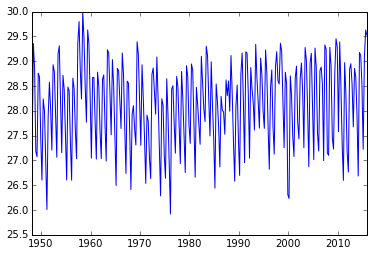

In [4]:

#find time series at point nearest to 10N and 95W
tser=sstdata.sel(lat=[10.],lon=[360.-95.],method='nearest')
tser

plt.figure()
plt.plot(tser['time'].values,tser['skt'].values.ravel())
#sst_resample



In [5]:
ls=xray.open_dataset('lsmask.19294.nc',decode_times=False)
ls['lsmask']

<xray.DataArray 'lsmask' (time: 1, lat: 94, lon: 192)>
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.],
        [-1., -1., -1., ..., -1., -1., -1.]]])
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 82.8508 80.9473 79.0435 ...
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.125 15.0 ...
  * time     (time) float64 -1.577e+07
Attributes:
    long_name: Surface land/sea mask
    valid_range: [-1.  1.]
    actual_range: [-1.  0.]
    units: none
    precision: 2
    var_desc: Land/Sea Mask
    level_desc: Surface
    statistic: Individual Obs
    parent_stat: Other
    dataset: NCEP Reanalysis Derived Products

<function matplotlib.pyplot.colorbar>

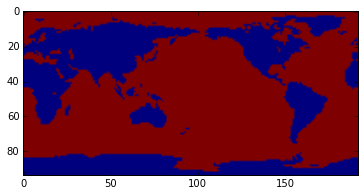

In [6]:
plt.figure()
plt.imshow(ls['lsmask'].values[0,:,:])
plt.colorbar

In [7]:
mask3d=ls['lsmask'].values.repeat(272,0)
np.shape(mask3d)

(272, 94, 192)

In [8]:
sstdata

<xray.Dataset>
Dimensions:  (lat: 94, lon: 192, time: 272)
Coordinates:
  * lat      (lat) float32 88.542 86.6531 84.7532 82.8508 80.9473 79.0435 ...
  * lon      (lon) float32 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.125 15.0 ...
  * time     (time) datetime64[ns] 1948-02-29 1948-05-31 1948-08-31 ...
Data variables:
    skt      (time, lat, lon) float32 -38.5333 -38.5388 -38.5811 -38.6714 ...

<matplotlib.colorbar.Colorbar instance at 0x7f39beebdd40>

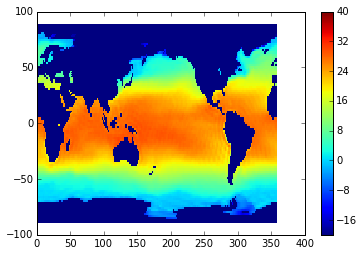

In [9]:
sstdata['skt'].values=np.ma.masked_where(mask3d == -1, sstdata['skt'].values)
plt.figure()
plt.pcolormesh(sstdata['lon'].values,sstdata['lat'].values,sstdata['skt'].values[0,:,:])
plt.clim([-20,40])
plt.colorbar()

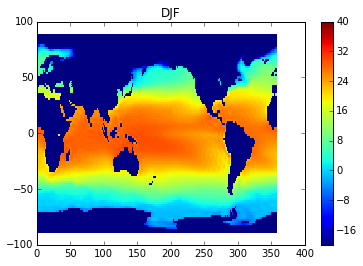

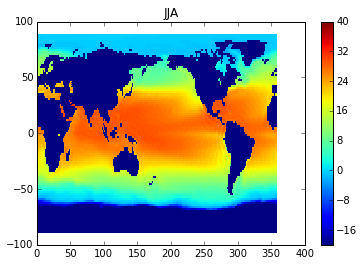

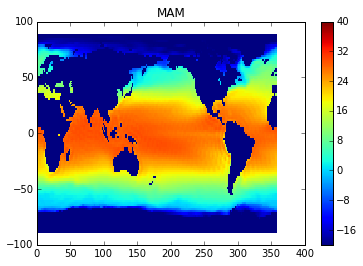

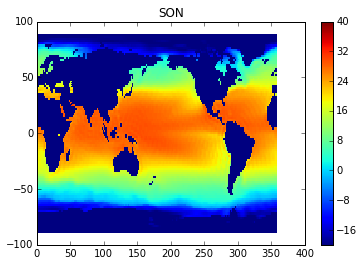

In [10]:
#calculate seasonal climatology

sstseas=sstdata.groupby('time.season').mean(dim='time')


for i in np.arange(4):
    plt.figure()
    plt.pcolormesh(sstseas['lon'].values,sstseas['lat'].values,sstseas['skt'].values[i,:,:])
    plt.clim([-20,40])
    plt.title(sstseas['season'].values[i])
    plt.colorbar()

In [11]:
import numpy as np

<matplotlib.colorbar.Colorbar instance at 0x7f39be822488>

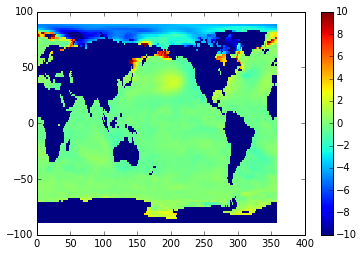

In [12]:

fixed_sstseas=xray.concat([sstseas.sel(season='DJF'),sstseas.sel(season='MAM'),sstseas.sel(season='JJA'),sstseas.sel(season='SON')],'season')

#resize (tile ) to be same shape as data
meansstseas=np.tile(fixed_sstseas['skt'].values,(68,1,1))

anomsst=sstdata['skt'].values-meansstseas

plt.pcolormesh(sstdata['lon'].values,sstdata['lat'].values,anomsst[4,:,:])
plt.clim([-10,10])
plt.colorbar()

In [13]:
def seas_departure(inputarr,field):
    seas=inputarr.groupby('time.season').mean(dim='time')
    fixed_seas=xray.concat([seas.sel(season='DJF'),seas.sel(season='MAM'),\
             seas.sel(season='JJA'),seas.sel(season='SON')], 'season')
    #calculates the seasonal climatology but np.tile gives you back a numpy array
    mean_seas=np.tile(fixed_seas[field].values,(68,1,1))
    #put it back into an xray dataset
    #foo = xray.DataArray(data, coords=[times, locs], dims=['time', 'space'])
    mean_seas=xray.DataArray(mean_seas,coords=[inputarr['time'].values,inputarr['lat'].values,\
                                             inputarr['lon'].values],dims=['time','lat','lon'])
    anom = inputarr[field].values-mean_seas
    return anom

anomsst=seas_departure(sstdata,'skt')
anomsst

<xray.DataArray (time: 272, lat: 94, lon: 192)>
array([[[-4.44317245, -4.42129898, -4.42863083, ..., -4.36367035,
         -4.38543701, -4.41463852],
        [-3.66640091, -3.62452698, -3.5991745 , ..., -3.80857468,
         -3.74745941, -3.69694901],
        [-2.69404984, -2.68140411, -2.68823242, ..., -2.91536331,
         -2.82406235, -2.74878693],
        ..., 
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 0.24821091,  0.236166  ,  0.22953606, ...,  0.2504406 ,
          0.23942375,  0.23883057],
        [-0.18886185, -0.17407227, -0.17473221, ..., -0.18044281,
         -0.18090248, -0.18618202],
        [-0.53155708, -0.53410149, -0.55817604, ..., -0.47854424,
         -0.48344994, -0.49978828],
        ..., 
    

<function matplotlib.pyplot.colorbar>

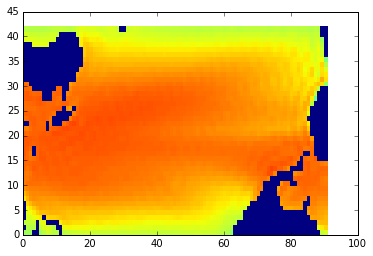

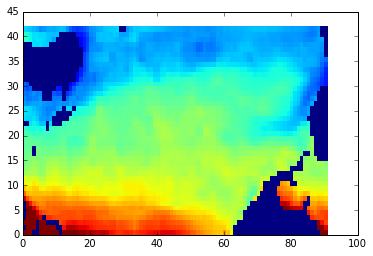

In [14]:
dsub = sstdata.sel(lat=slice(40,-40), lon=slice(120,290))
lat = dsub['lat'].values
lon = dsub['lon'].values




#calculate sst climatology
meansst=dsub['skt'].mean(axis=0)


plt.figure()
plt.pcolormesh(meansst.values) 
plt.clim([-20,40])
plt.colorbar

#resize to be the same shape as the data
meansst=meansst.values.reshape(1,np.shape(meansst)[0],np.shape(meansst)[1]).repeat(272,0)

#anomalies
anomsst=dsub['skt'].values-meansst
lons,lats = np.meshgrid(lon,lat)

plt.figure()
plt.pcolormesh(anomsst[2,:,:])  #summer in NH
plt.clim([-5,5])
plt.colorbar

In [15]:
X = np.reshape(anomsst, (anomsst.shape[0], len(lat) * len(lon)), order='F')
X.shape

(272, 3822)

In [16]:
X = ma.masked_array(X, np.isnan(X))
type(X)
land = X.sum(0).mask
ocean=-land
X = X[:,ocean]
X.shape

(272, 3356)

In [17]:
from sklearn import preprocessing
scaler  = preprocessing.StandardScaler()
scaler_sst = scaler.fit(X)
X = scaler_sst.transform(X)
from sklearn.decomposition import pca
skpca = pca.PCA()
skpca.fit(X)

PCA(copy=True, n_components=None, whiten=False)

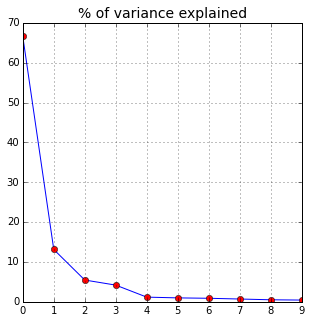

In [18]:
f, ax = plt.subplots(figsize=(5,5))
ax.plot(skpca.explained_variance_ratio_[0:10]*100)
ax.plot(skpca.explained_variance_ratio_[0:10]*100,'ro')
ax.set_title("% of variance explained", fontsize=14)
ax.grid()

In [19]:
PCs = skpca.transform(X)
EOFs = skpca.components_

ipc=272
EOF_recons = np.ones((ipc, len(lat) * len(lon))) * -999.

for i in range(ipc): 
    EOF_recons[i,ocean] = EOFs[i,:]
EOF_recons = ma.masked_values(np.reshape(EOF_recons, (ipc, len(lat), len(lon)), order='F'), -999.)
EOF_recons.shape

(272, 42, 91)

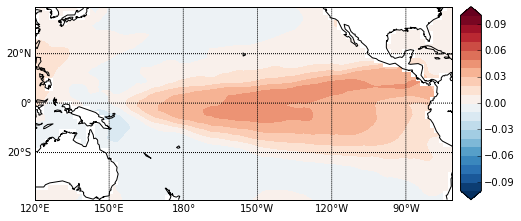

In [20]:
def plot_field(m, X, lats, lons, vmin, vmax, step, cmap=plt.get_cmap('jet'), \
               ax=False, title=False, grid=False):
    if not ax: 
        f, ax = plt.subplots(figsize=(8, (X.shape[0] / float(X.shape[1])) * 8))
    m.ax = ax
    im = m.contourf(lons, lats, X, np.arange(vmin, vmax+step, step), \
                    latlon=True, cmap=cmap, extend='both', ax=ax)
    m.drawcoastlines()
    if grid: 
        m.drawmeridians(np.arange(0, 360, 30), labels=[0,0,0,1])
        m.drawparallels(np.arange(-80, 80, 20), labels=[1,0,0,0])
    m.colorbar(im)
    if title: 
        ax.set_title(title)
        
m = bm(projection='cyl',llcrnrlat=lat.min(),urcrnrlat=lat.max(),\
            llcrnrlon=lon.min(),urcrnrlon=lon.max(),\
            lat_ts=0,resolution='c')

plot_field(m, EOF_recons[1,:,:], lats,lons, -.1 ,.1, .01, grid =True, cmap=plt.get_cmap('RdBu_r'))

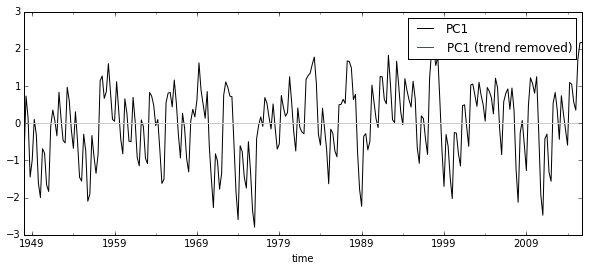

In [21]:
from sklearn.preprocessing import StandardScaler
scaler_PCs = StandardScaler()
scaler_PCs.fit(PCs)
PCs_std = scaler_PCs.transform(PCs)
PCdf = pd.DataFrame(PCs_std, index = dsub['time'], \
                    columns = ["EOF%s" % (x) for x in range(1, PCs_std.shape[1] +1)])
from scipy.signal import detrend
f, ax = plt.subplots(figsize=(10,4))
PCdf.ix[:,1].plot(ax=ax, color='k', label='PC1')
ax.axhline(0, c='0.8')
#ax.set_xlabel('period', fontsize=18)
ax.plot(PCdf.index, detrend(PCdf.ix[:,1].values), 'r',  label='PC1 (trend removed)')
ax.grid('off')
ax.legend(loc=1); 

(2) Create normalized index values (mean=0, sd=1) of Sea Level Pressure between Tahiti and Darwin similar to Fig. 4.  Invert the index (multiply by -1, as in the paper).  Plot the time series.

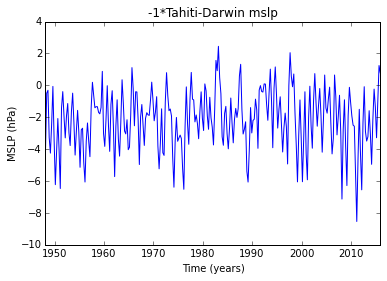

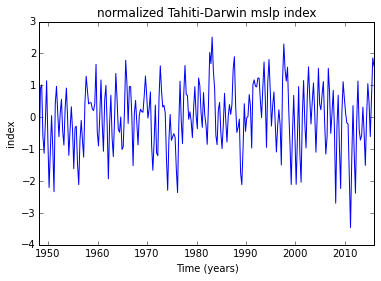

In [22]:
slp=xray.open_dataset('slp_seas_ncep.nc')
slp
tahitimslp = slp.sel(lat=-15., lon=360-149.,method='nearest')
tahitimslp

darwinmslp = slp.sel(lat=-12., lon=131.,method='nearest')
darwinmslp
plt.figure()
plt.plot(tahitimslp['time'].values,-1*(tahitimslp['slp'].values-darwinmslp['slp'].values))
plt.title('-1*Tahiti-Darwin mslp')
plt.ylabel('MSLP (hPa)')
plt.xlabel('Time (years)')

#calculate normalized index, with mean=0 and std=1
diff=-1*(tahitimslp['slp']-darwinmslp['slp'])
diff=(diff-np.mean(diff))
diff=diff/np.std(diff)
diff

plt.figure()
plt.plot(diff['time'].values,diff)
plt.title('normalized Tahiti-Darwin mslp index')
plt.ylabel('index')
plt.xlabel('Time (years)')

(3) Create normalized index values of 200 hPa height at the stations listed in Fig 6.  Plot the time series.

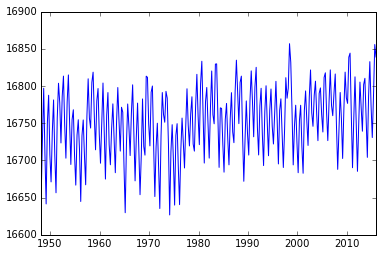

In [23]:
h200=xray.open_dataset('h200_seas_ncep.nc')

#west(lon) and south(lat) negative
sites=       ['NAI' ,'DAR' , 'NAN' ,'HIL'  , 'SAJ']
lat=np.array([-1.2, -12.4, -17.5,   19.7,   18.0])
lon=np.array([36.8, 130.0,  177.0, -155.0, -66.0])

def grab_h200(h200,lat,lon):
    return h200.sel(lat=lat,lon=360-lon, method='nearest')

all_h200={}
for i in np.arange(len(lat)):
    all_h200[sites[i]]=grab_h200(h200,lat[i],lon[i])
    
    
z200index=0.2*all_h200['NAI']+0.23*all_h200['DAR']+0.23*all_h200['NAN']+0.25*all_h200['HIL']+0.27*all_h200['SAJ']



plt.plot(z200index['time'].values,z200index['hgt'].values)

def standardize(var):
    var=var-np.mean(var)
    return var/np.std(var)

z200index_std=standardize(z200index)


(4) Compute the PNA and WP indices as on p. 823 of the paper. Plot the time series.

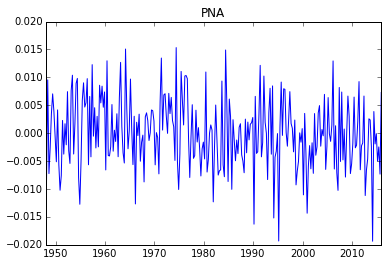

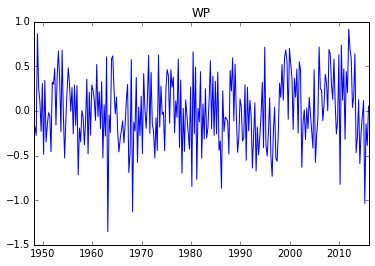

In [24]:
h700=xray.open_dataset('h700_seas_ncep.nc')

sites=       ['A' ,'B' ,'C' ,'D' , 'E']
lat=np.array([55,  45,  30,  30,  60])
lon=np.array([-115, -165, -85, 155, 155])

def seas_departure(inputarr,field):
    h700=inputarr.groupby('time.season').mean(dim='time')
    fixed_h700=xray.concat([h700.sel(season='DJF'),h700.sel(season='MAM'),h700.sel(season='JJA'),h700.sel(season='SON')],'season')
    #calculates the seasonal climatology but np.tile gives you back a numpy array 
    mean_h700=np.tile(fixed_h700[field].values,(68,1,1)) 
    #put it back into an xray dataset
    mean_h700=xray.DataArray(mean_h700,coords=[inputarr['time'].values,inputarr['lat'].values,inputarr['lon'].values],dims=['time','lat','lon'])
    anom=inputarr[field].values-mean_h700
    return anom 

anomhgt=seas_departure(h700,'hgt')
anomhgt_seas=anomhgt.groupby('time.season').mean(dim='time')
winteranomhgt=anomhgt_seas.sel(season='DJF')
def grab_h700(winteranomhgt,lat,lon):
    return winteranomhgt.sel(lat=lat,lon=360-lon, method='nearest')

all_h700={}
for i in np.arange(len(lat)):
   all_h700[sites[i]]=grab_h700(h700,lat[i],lon[i])
    
def standardize(all_h700_norm):
    all_h700_norm=all_h700_norm-np.mean(all_h700_norm)
    return all_h700_norm/np.std(all_h700_norm)

normalized_anomhgt = standardize(winteranomhgt)

all_h700_normA=standardize(all_h700['A']['hgt'])
all_h700_normB=standardize(all_h700['B']['hgt'])
all_h700_normC=standardize(all_h700['C']['hgt'])
all_h700_normD=standardize(all_h700['D']['hgt'])
all_h700_normE=standardize(all_h700['E']['hgt'])

PNAz700index=(all_h700_normA)-0.5*((all_h700_normB)+(all_h700_normC))
PNAz700index=PNAz700index/100
WPz700index=0.5*((all_h700_normD)-(all_h700_normE))


plt.plot(h700['time'],PNAz700index)
plt.title('PNA')

plt.figure()
plt.plot(h700['time'],WPz700index)
plt.title('WP')


(5) Compute standardized rainfall values at the locations in Fig. 3. Plot the time series.

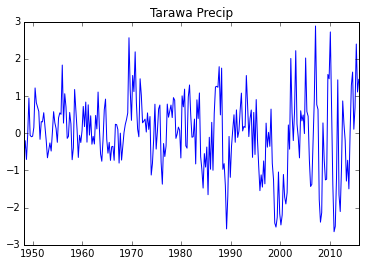

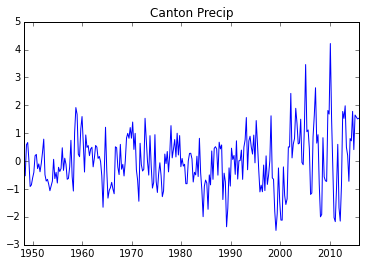

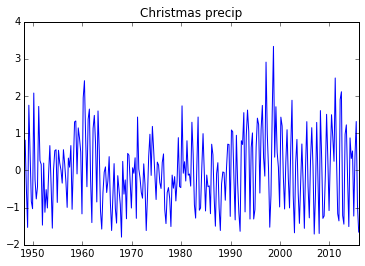

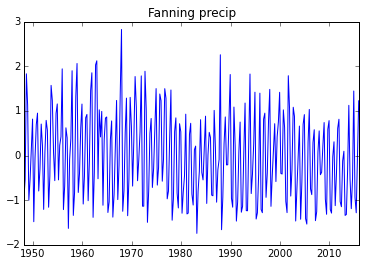

In [25]:
import xray
precips=xray.open_dataset('precip_seas_ncep.nc')

def seas_departure(inputarr,field):
    precips=inputarr.groupby('time.season').mean(dim='time')
    fixed_seas=xray.concat([precips.sel(season='DJF'),precips.sel(season='MAM'),precips.sel(season='JJA'),precips.sel(season='SON')],'season')
    #calculates the seasonal climatology but np.tile gives you back a numpy array 
    mean_precip=np.tile(fixed_seas[field].values,(68,1,1)) 
    #put it back into an xray dataset
    mean_precip=xray.DataArray(mean_precip,coords=[inputarr['time'].values,inputarr['lat'].values,inputarr['lon'].values],dims=['time','lat','lon'])
    anom=inputarr[field].values-mean_precip
    return anom 


anomprecip=seas_departure(precips,'prate')
anomprecip_seas=anomprecip.groupby('time.season').mean(dim='time')
#print(anomprecip_seas)
DJF=anomprecip_seas.sel(season='DJF')




sites=['tarawa', 'canton','christmas', 'fanning'] 
lat=[1.4,-2.8,-10.5,19.7, 3.9]
lon=[173.0,171.0, 105.6, 159.4] 
def grab_precip(DJF,lat,lon):
    return DJF.sel(lat=lat, lon=lon, method='nearest')

all_precip={}
for i in np.arange(len(lon)):
    all_precip[sites[i]]=np.squeeze(grab_precip(precips,lat[i],lon[i]))

    
#precipindex=0.2*all_precip['tarawa']+0.23*all_precip['canton']+0.23*all_precip['christmas']+0.25*all_precip['fanning']
tarawaprecip=all_precip['tarawa']
def standardize(var):
    var=var-np.mean(var)
    return var/np.std(var)
tarawaprecip_std=standardize(tarawaprecip)
np.abs(tarawaprecip)

plt.plot(tarawaprecip_std['time'].values,tarawaprecip_std['prate'].values)
plt.title('Tarawa Precip')



cantonprecip=all_precip['canton']
def standardize(var):
    var=var-np.mean(var)
    return var/np.std(var)
cantonprecip_std=standardize(cantonprecip)
plt.figure()
plt.plot(cantonprecip_std['time'].values,cantonprecip_std['prate'].values)
plt.title('Canton Precip')

christmasprecip=all_precip['christmas']
def standardize(var):
    var=var-np.mean(var)
    return var/np.std(var)
christmasprecip_std=standardize(christmasprecip)
plt.figure()
plt.plot(christmasprecip_std['time'].values,christmasprecip_std['prate'].values)
plt.title('Christmas precip')

fanningprecip=all_precip['fanning']
def standardize(var):
    var=var-np.mean(var)
    return var/np.std(var)
fanningprecip_standard=standardize(fanningprecip)
plt.figure()
plt.plot(fanningprecip_standard['time'].values,fanningprecip_standard['prate'].values)
plt.title('Fanning precip')

(6) Reproduce Fig 8 with the top 4 and bottom 4 values of PNA index (that you find in part 4), except contour the values you have rather than plot points as in the paper.

In [26]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

sort_pnaindex=sorted(PNAz700index)
pna_max=sort_pnaindex[268:272]
#print(pna_max)
pna_min=sort_pnaindex[0:4]
#print(pna_min)
top=[]
for i in range(4):
     top.append(anomhgt.sel(time=pna_max[i]['time']))
    
top=xray.concat(top, 'time')
top=top.mean(axis=0)
print(top)

#print(pnaindex['time'] == pna_max[0]['time'])

bottom=[]
for i in range(4):
    bottom.append(anomhgt.sel(time=pna_min[i]['time']))

bottom=xray.concat(bottom, 'time')
bottom=bottom.mean(axis=0)

print(bottom)

<xray.DataArray (lat: 73, lon: 144)>
array([[-15.59954834, -15.59954834, -15.59954834, ..., -15.59954834,
        -15.59954834, -15.59954834],
       [-15.76940918, -15.79699707, -15.89117432, ..., -15.61383057,
        -15.67419434, -15.73535156],
       [-14.08312988, -14.15411377, -14.24456787, ..., -13.86645508,
        -13.95318604, -14.01708984],
       ..., 
       [ -4.82592773,  -4.98638916,  -5.10400391, ...,  -4.1809082 ,
         -4.41564941,  -4.63305664],
       [ -3.265625  ,  -3.32556152,  -3.36260986, ...,  -3.03314209,
         -3.12390137,  -3.19586182],
       [ -0.11462402,  -0.11462402,  -0.11462402, ...,  -0.11462402,
         -0.11462402,  -0.11462402]], dtype=float32)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 77.5 75.0 72.5 70.0 67.5 ...
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
<xray.DataArray (lat: 73, lon: 144)>
array([[ 29.49163818,  29.49163818,  29.49163818, ...,  29.49163818,
         29.49163818,

In [27]:
anomhgt.sel(time=pna_max[0]['time'])

<xray.DataArray (lat: 73, lon: 144)>
array([[ 12.68164062,  12.68164062,  12.68164062, ...,  12.68164062,
         12.68164062,  12.68164062],
       [  8.12768555,   8.28515625,   8.36499023, ...,   7.95947266,
          8.00756836,   8.07861328],
       [  2.88061523,   3.16918945,   3.42114258, ...,   2.28393555,
          2.39550781,   2.55737305],
       ..., 
       [  8.55053711,   8.57958984,   8.56884766, ...,   8.51074219,
          8.54296875,   8.50366211],
       [  7.95922852,   7.98461914,   8.05810547, ...,   7.87744141,
          7.92236328,   7.92333984],
       [ 11.85131836,  11.85131836,  11.85131836, ...,  11.85131836,
         11.85131836,  11.85131836]], dtype=float32)
Coordinates:
    time     datetime64[ns] 1971-05-31
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 77.5 75.0 72.5 70.0 67.5 ...
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...

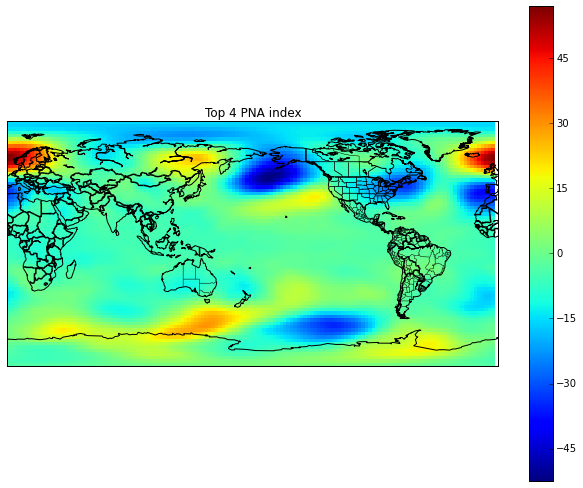

In [28]:
h700=xray.open_dataset('h700_seas_ncep.nc')
lat_1d = h700['lat'].values
lon_1d = h700['lon'].values
pna_2d = top.values
lat_1d = lat_1d[:].squeeze()  
lon_1d = lon_1d[:].squeeze()
lon_2d, lat_2d = np.meshgrid(lon_1d, lat_1d)

fig=plt.figure(figsize=(11,8.5))  
map = Basemap(lon_0=180)


CS=map.pcolormesh(lon_2d, lat_2d, pna_2d)
#plt.clabel(CS,inline=1, fontsize=14, fmt='%1.0f') 
plt.colorbar()
plt.title('Top 4 PNA index')

map.drawcoastlines()  
map.drawstates()

map.drawcountries(linewidth=1.5)
plt.show()

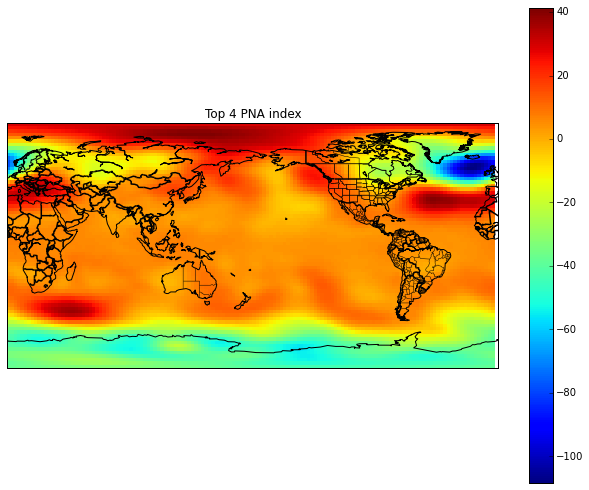

In [29]:
h700=xray.open_dataset('h700_seas_ncep.nc')
lat_1d = h700['lat'].values
lon_1d = h700['lon'].values
pna_2d = bottom.values
lat_1d = lat_1d[:].squeeze()  
lon_1d = lon_1d[:].squeeze()
lon_2d, lat_2d = np.meshgrid(lon_1d, lat_1d)

fig=plt.figure(figsize=(11,8.5))  
map = Basemap(lon_0=180)


CS=map.pcolormesh(lon_2d, lat_2d, pna_2d)
#plt.clabel(CS,inline=1, fontsize=14, fmt='%1.0f') 
plt.colorbar()
plt.title('Top 4 PNA index')

map.drawcoastlines()  
map.drawstates()

map.drawcountries(linewidth=1.5)
plt.show()

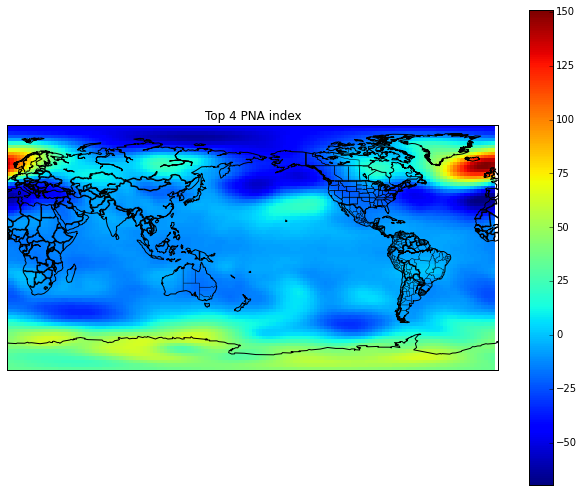

In [30]:
h700=xray.open_dataset('h700_seas_ncep.nc')
lat_1d = h700['lat'].values
lon_1d = h700['lon'].values
pna_2d = (top-bottom).values
lat_1d = lat_1d[:].squeeze()  
lon_1d = lon_1d[:].squeeze()
lon_2d, lat_2d = np.meshgrid(lon_1d, lat_1d)

fig=plt.figure(figsize=(11,8.5))  
map = Basemap(lon_0=180)


CS=map.pcolormesh(lon_2d, lat_2d, pna_2d)
#plt.clabel(CS,inline=1, fontsize=14, fmt='%1.0f') 
plt.colorbar()
plt.title('Top 4 PNA index')

map.drawcoastlines()  
map.drawstates()

map.drawcountries(linewidth=1.5)
plt.show()

(7) Recreate Figure 9 using your data.

In [31]:
#200 hPa - 700 hPa correlation map

z200index_std['hgt']

h700=xray.open_dataset('h700_seas_ncep.nc')
print(np.shape(h700['hgt'].values))

def spatial_corr(index,mapvals):
    sz=np.shape(mapvals)
    
    outmap=np.zeros([sz[1],sz[2]])
    for i in np.arange(sz[1]):
        for j in np.arange(sz[2]):
            maptser=np.squeeze(mapvals[:,i,j])
            #print(np.shape(maptser))
            #print(np.shape(index))
            df_bis = pd.DataFrame({'maptser': maptser,
                       'index': np.squeeze(index)})
            outmap[i,j]=df_bis.corr().values[1,0]
            
    return outmap

(272, 73, 144)


<matplotlib.colorbar.Colorbar instance at 0x7f39bed4e290>

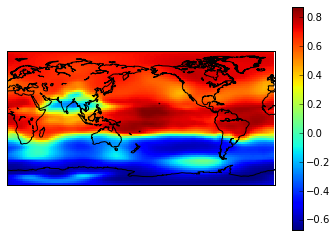

In [32]:
outmap=spatial_corr(z200index_std['hgt'].values,h700['hgt'].values)
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
# setup north polar stereographic basemap.
# The longitude lon_0 is at 6-o'clock, and the
# latitude circle boundinglat is tangent to the edge
# of the map at lon_0. Default value of lat_ts
# (latitude of true scale) is pole.
m = Basemap(lon_0=180)

m.pcolormesh(h700['lon'].values,h700['lat'].values,outmap)
m.drawcoastlines()
plt.colorbar()


<matplotlib.colorbar.Colorbar instance at 0x7f39b4a120e0>

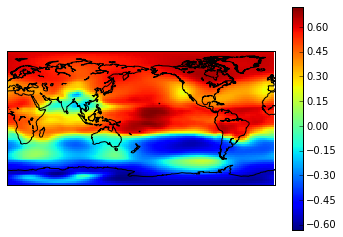

In [33]:
outmap=spatial_corr(tser['skt'].values,h700['hgt'].values)
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
# setup north polar stereographic basemap.
# The longitude lon_0 is at 6-o'clock, and the
# latitude circle boundinglat is tangent to the edge
# of the map at lon_0. Default value of lat_ts
# (latitude of true scale) is pole.
m = Basemap(lon_0=180)

m.pcolormesh(h700['lon'].values,h700['lat'].values,outmap)
m.drawcoastlines()
plt.colorbar()



In [34]:
outmap=spatial_corr(fanningprecip_standard.values,h700['hgt'].values)
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt

m = Basemap(lon_0=180)

m.pcolormesh(h700['lon'].values,h700['lat'].values,outmap)
m.drawcoastlines()
plt.colorbar()

#fanning

IndexError: index 1 is out of bounds for axis 0 with size 1

<matplotlib.colorbar.Colorbar instance at 0x7f39f404a7a0>

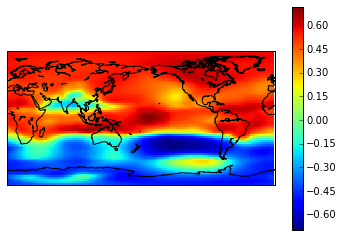

In [35]:
outmap=spatial_corr(diff.values,h700['hgt'].values)
from mpl_toolkits.basemap import Basemap
import numpy as np
import matplotlib.pyplot as plt
# setup north polar stereographic basemap.
# The longitude lon_0 is at 6-o'clock, and the
# latitude circle boundinglat is tangent to the edge
# of the map at lon_0. Default value of lat_ts
# (latitude of true scale) is pole.
m = Basemap(lon_0=180)

m.pcolormesh(h700['lon'].values,h700['lat'].values,outmap)
m.drawcoastlines()
plt.colorbar()

#2